In [5]:
import os
import sys

def add_to_sys_path(relative_path):
    abs_path = os.path.abspath(os.path.join(os.getcwd(), relative_path))
    if abs_path not in sys.path:
        sys.path.append(abs_path)

add_to_sys_path(os.path.join('..', '..', '..', 'Utils'))
add_to_sys_path(os.path.join('..', '..', '..', 'Model'))

In [2]:
! pip install wayback

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 kB 667.3 kB/s eta 0:00:000:01


In [6]:
import pandas as pd
import numpy as np
import random
import shap

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from MLP import base_model as base_model_call
from model_data_processing import Data_Handler, Model_Metrics_Visualizer
from output_shuffling_attack import *

/home/jn/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [7]:
data = pd.read_csv('../../../Dataset/PhiUSIIL_Phishing_URL_Dataset.csv')
data.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,...,1,0,1,244,15,34,72,1,85,1


In [8]:
data = data.drop(data.select_dtypes(include='object').columns, axis=1)
print(data[data['label']==0]['IsHTTPS'].value_counts())
print(data[data['label']==1]['IsHTTPS'].value_counts())
data.head()

IsHTTPS
0    51256
1    49689
Name: count, dtype: int64
IsHTTPS
1    134850
Name: count, dtype: int64


,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,31,24,0,100.0,1.000000,0.522907,0.061933,3,1,0,...,0,0,1,34,20,28,119,0,124,1
1,23,16,0,100.0,0.666667,0.032650,0.050207,2,1,0,...,0,0,1,50,9,8,39,0,217,1
2,29,22,0,100.0,0.866667,0.028555,0.064129,2,2,0,...,0,0,1,10,2,7,42,2,5,1
3,26,19,0,100.0,1.000000,0.522907,0.057606,3,1,0,...,1,1,1,3,27,15,22,1,31,1
4,33,26,0,100.0,1.000000,0.079963,0.059441,3,1,0,...,1,0,1,244,15,34,72,1,85,1


In [9]:
protected_feature='IsHTTPS'
superior_outcome_value = 1

In [ ]:
x_train, x_test, y_train, y_test, feature_names, scaler = Data_Handler(
        df=data,
        target_column='label',
        protected_feature=protected_feature,
        do_scaling=True,
        correlation_threshold=0.35,
        test_size=0.3,
        random_state=0
    )


Applying feature correlation removal...


Scaling numerical features: ['URLLength', 'DomainLength', 'TLDLegitimateProb', 'LineOfCode', 'LargestLineLength', 'NoOfPopup', 'NoOfiFrame', 'NoOfCSS', 'NoOfEmptyRef']


In [11]:
print(len(x_train.columns))
x_train.head()

19


,URLLength,DomainLength,IsDomainIP,TLDLegitimateProb,HasObfuscation,IsHTTPS,LineOfCode,LargestLineLength,Robots,NoOfURLRedirect,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasPasswordField,Bank,Pay,Crypto,NoOfCSS,NoOfEmptyRef
98258,-0.134650,0.059642,0,-0.922760,0,1,-0.185396,-0.077576,0,0,-0.053741,0.067997,0,0,0,0,0,-0.015936,0.032389
131577,-0.231504,-0.379189,0,-0.922760,0,1,0.422297,-0.074531,0,0,-0.053741,-0.095874,0,0,0,0,0,-0.060824,0.350060
201592,-0.183077,-0.159773,0,1.041476,0,1,0.180121,-0.075475,1,0,-0.053741,-0.259745,0,0,0,0,0,-0.049602,0.032389
159643,-0.134650,0.059642,0,-1.028299,0,1,1.472474,-0.056584,0,0,-0.053741,3.345417,0,1,1,1,0,-0.049602,0.138279
170726,-0.328358,-0.818020,0,-0.964647,0,1,-0.184108,-0.016243,1,0,-0.053741,0.067997,0,0,1,0,1,0.230949,-0.020556


Accuracy: 0.9992790398507189
Precision: 0.9992794354659729
Recall: 0.9992790398507189
F-1: 0.9992789879241111


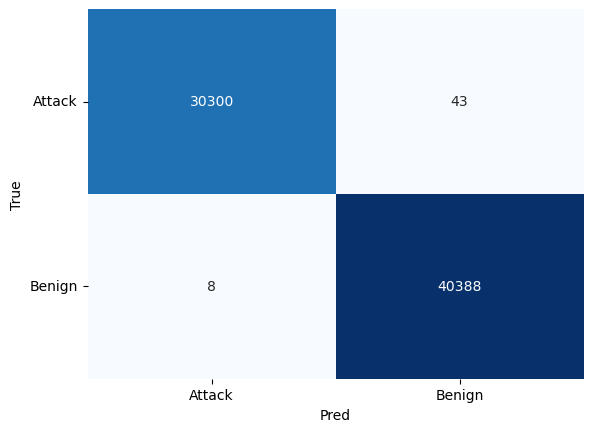

In [12]:
model = base_model_call(x_train, y_train, protected_feature, True)
y_pred = model.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred)


SHAP Explanations for the BASE Model (f)
Using 1000 samples from x_test for SHAP explanation calculation.


PermutationExplainer explainer: 1001it [06:35,  2.49it/s]                          


SHAP Summary (Base Model - using 1000 test samples)


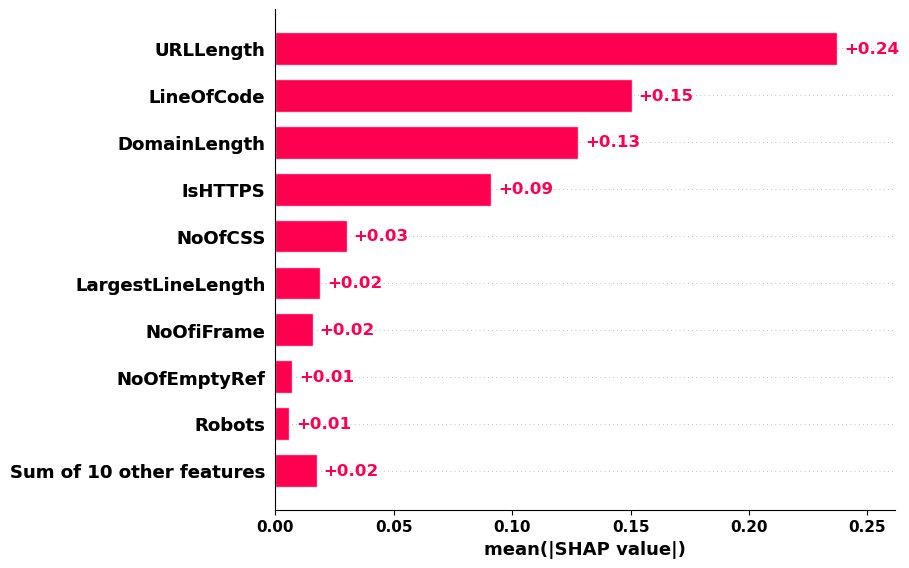

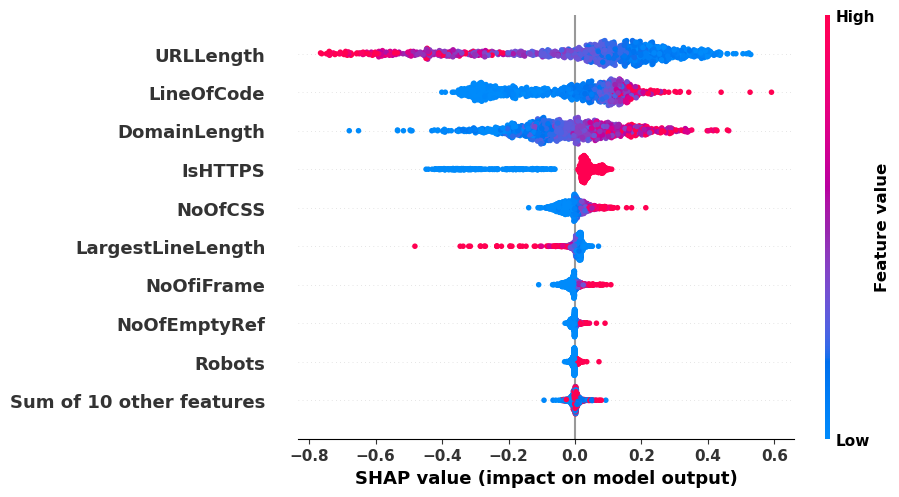

Mean |SHAP| for IsHTTPS (Base Model): 0.0912
           feature    importance  original_index
0        URLLength  2.373464e-01               0
1       LineOfCode  1.505878e-01               6
2     DomainLength  1.280465e-01               1
3          IsHTTPS  9.120594e-02               5
17      IsDomainIP  7.964768e-07               2
18  HasObfuscation  0.000000e+00               4


/home/jn/Desktop/Adversarial_Attack_On_XAI/Utils/output_shuffling_attack.py:755: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


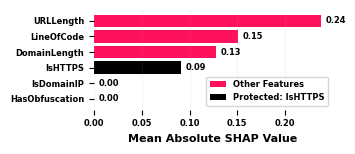

In [13]:
Base_Model_Explanation(x_test, model, protected_feature, feature_names, superior_outcome_value)

Accuracy: 0.9981198490224629
Precision: 0.9981207303022811
Recall: 0.9981198490224629
F-1: 0.9981196279861242


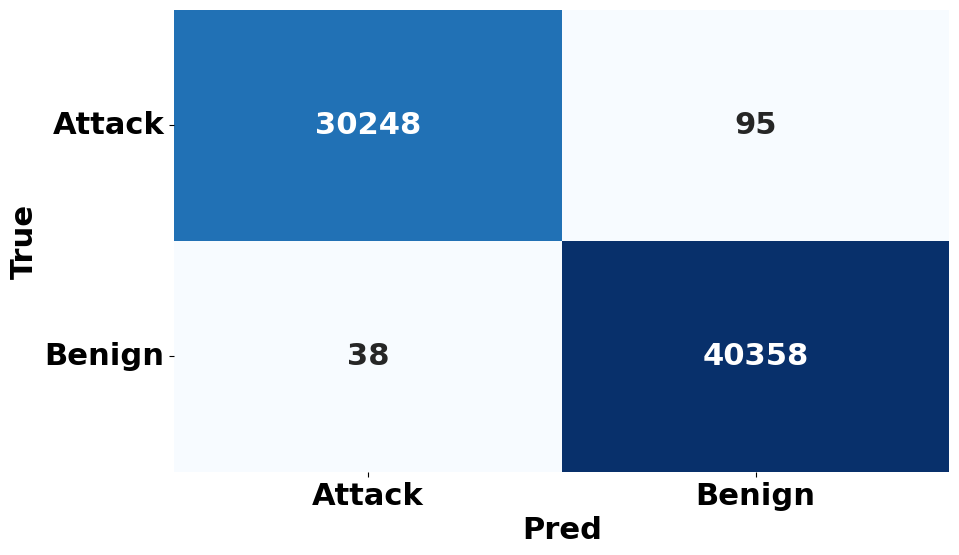

In [14]:
#now we will use the model without the protected feature as paper suggests
model = base_model_call(x_train, y_train, protected_feature, False)
y_pred = model.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred)

Using 1000 samples from x_test for SHAP explanation calculation.

SHAP Explanations for the ATTACK Model (f') - Dominance Attack


PermutationExplainer explainer: 1001it [17:58,  1.08s/it]                          


SHAP Summary (Attack Model - using 1000 test samples)


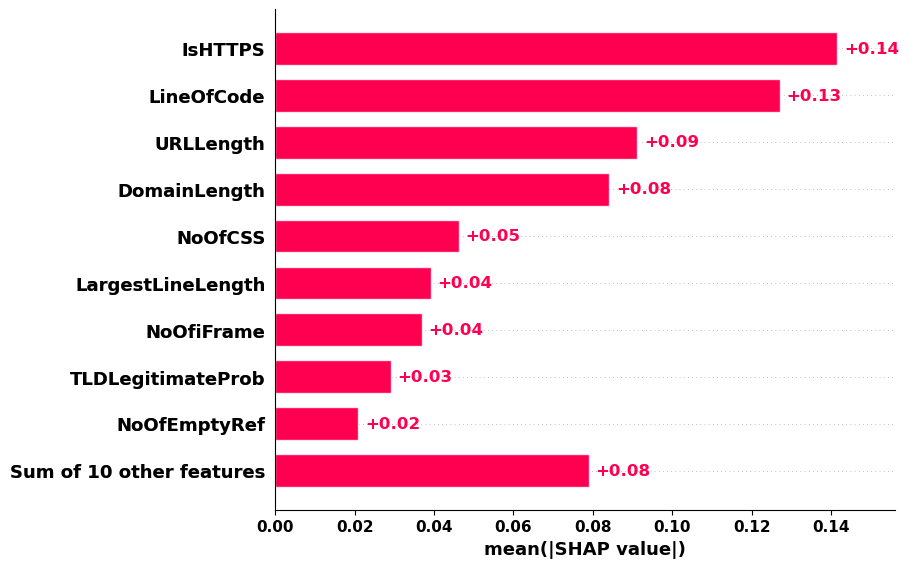

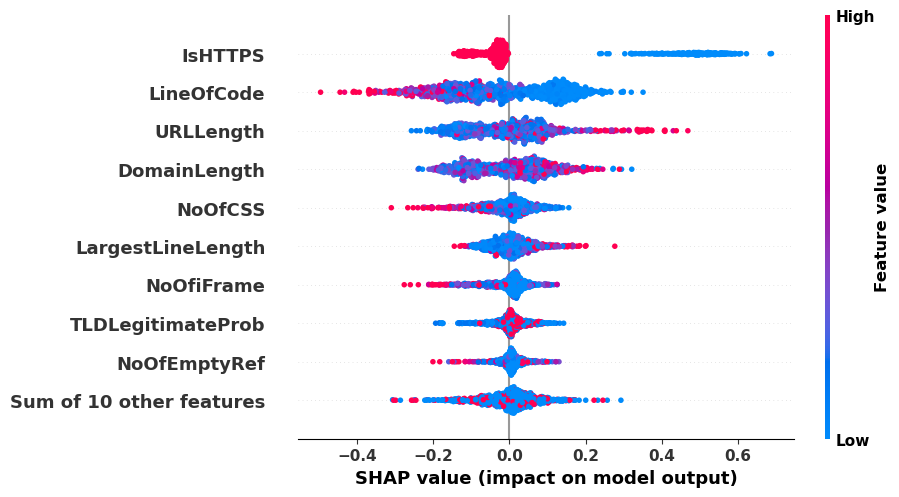

Mean |SHAP| for IsHTTPS (Attack Model - Dominance): 0.1416
           feature  importance  original_index
0          IsHTTPS    0.141632               5
1       LineOfCode    0.127189               6
2        URLLength    0.091237               0
17      IsDomainIP    0.000144               2
18  HasObfuscation    0.000000               4


/home/jn/Desktop/Adversarial_Attack_On_XAI/Utils/output_shuffling_attack.py:843: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


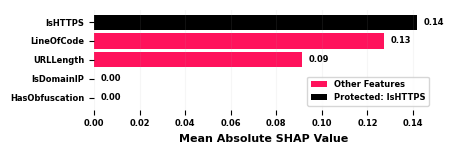

In [15]:
run_attack_analysis(x_test=x_test, base_model=model, feature_names=feature_names,
                        superior_outcome_value=1, protected_feature=protected_feature,
                        attack_type='dominance', attack_params = {protected_feature: 0},
                        shap_sample_size = 1000, random_state = 42)

Using 1000 samples from x_test for SHAP explanation calculation.

SHAP Explanations for the ATTACK Model (f') - Mixing Attack


PermutationExplainer explainer: 1001it [08:07,  2.03it/s]                          


SHAP Summary (Attack Model - using 1000 test samples)


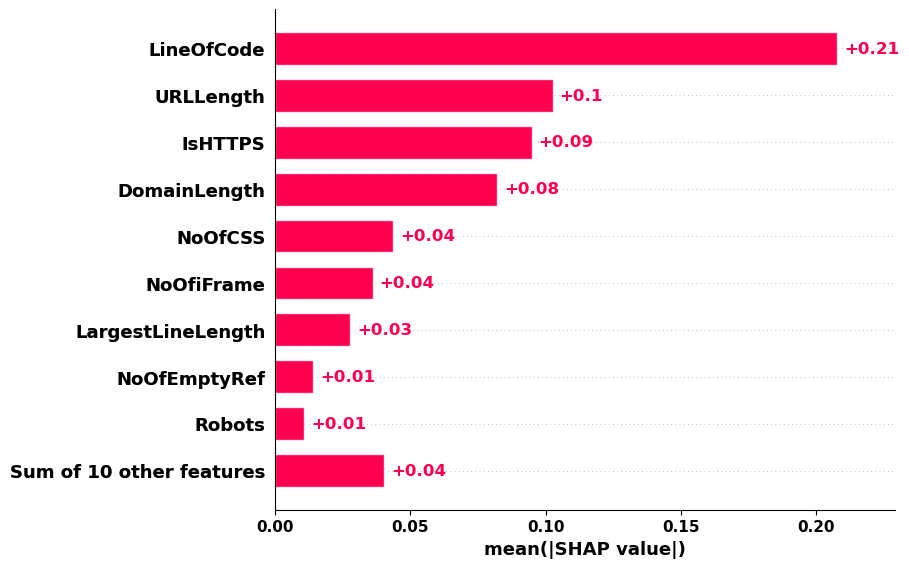

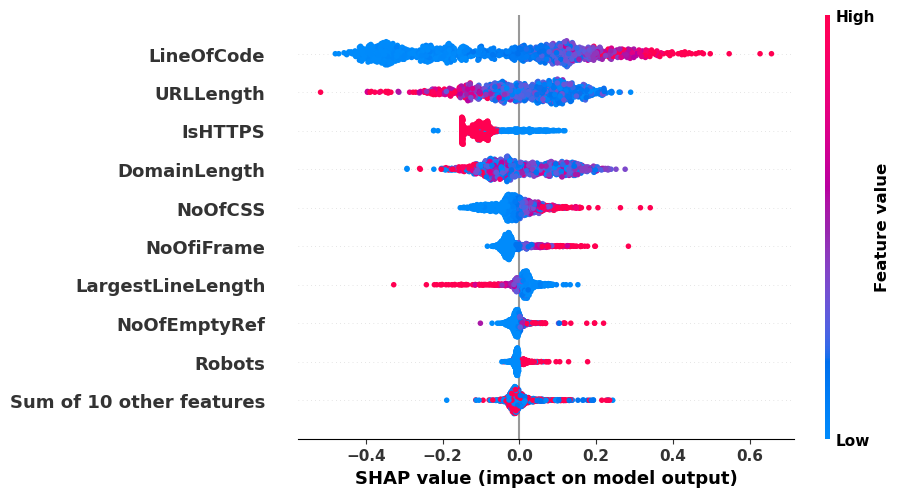

Mean |SHAP| for IsHTTPS (Attack Model - Mixing): 0.0949
           feature  importance  original_index
0       LineOfCode    0.207888               6
1        URLLength    0.102602               0
2          IsHTTPS    0.094949               5
17      IsDomainIP    0.000127               2
18  HasObfuscation    0.000000               4


/home/jn/Desktop/Adversarial_Attack_On_XAI/Utils/output_shuffling_attack.py:843: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


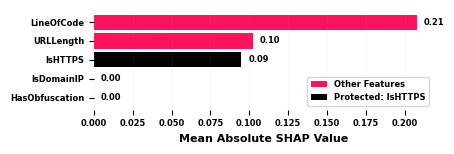

In [16]:
run_attack_analysis(x_test=x_test, base_model=model, feature_names=feature_names,
                        superior_outcome_value=1, protected_feature=protected_feature,
                        attack_type='mixing', attack_params = {protected_feature: 0, 'bias_strength': 0.7},
                        shap_sample_size = 1000, random_state = 42)

Using 1000 samples from x_test for SHAP explanation calculation.

SHAP Explanations for the ATTACK Model (f') - Swapping Attack


PermutationExplainer explainer: 1001it [06:57,  2.36it/s]                          


SHAP Summary (Attack Model - using 1000 test samples)


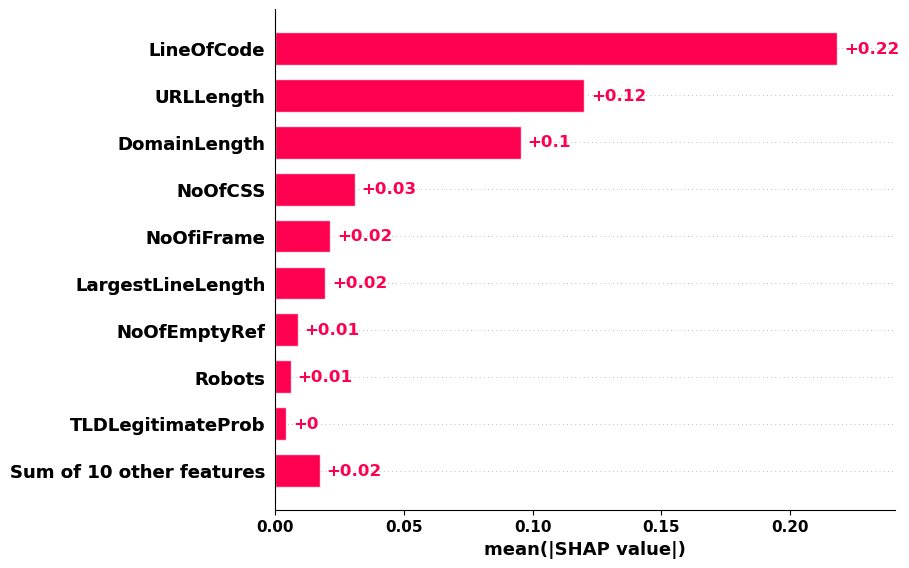

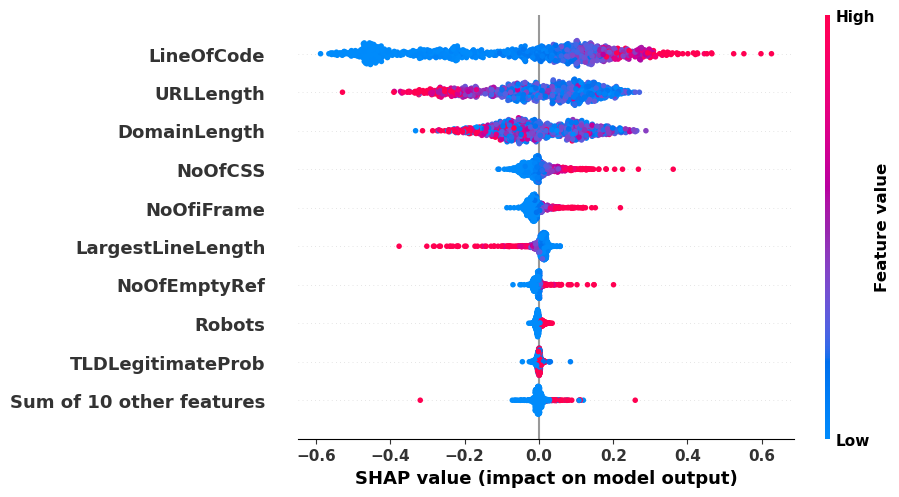

Mean |SHAP| for IsHTTPS (Attack Model - Swapping): 0.0002
           feature  importance  original_index
0       LineOfCode    0.218371               6
1        URLLength    0.120083               0
2     DomainLength    0.095499               1
16         IsHTTPS    0.000223               5
17      IsDomainIP    0.000213               2
18  HasObfuscation    0.000000               4


/home/jn/Desktop/Adversarial_Attack_On_XAI/Utils/output_shuffling_attack.py:843: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


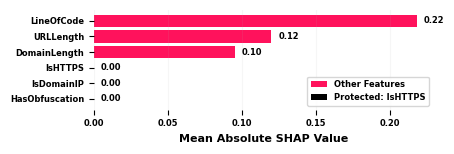

In [17]:
run_attack_analysis(x_test=x_test, base_model=model, feature_names=feature_names,
                        superior_outcome_value=1, protected_feature=protected_feature,
                        attack_type='swapping', attack_params = {protected_feature: 0},
                        shap_sample_size = 1000, random_state = 42)

In [18]:
print("Generating score-based visualization...")
fig_scores = visualize_all_attack_scores_parallel_coords(
        x_test=x_test,
        base_model=model,
        protected_feature=protected_feature,
        superior_outcome_value=1,
        sample_size=500
    )
fig_scores.show()

Generating score-based visualization...


In [19]:
print("\nGenerating ID rank change visualization...")
fig_ranks = visualize_all_attack_ranks_parallel_coords(
        x_test=x_test,
        base_model=model,
        protected_feature=protected_feature,
        superior_outcome_value=1,
        sample_size=500
    )
fig_ranks.show()


Generating ID rank change visualization...
